**Udemy 6-13. RNN for Image Classification (Code)**

Note: Run on GPU

# Image Classification Using LSTM (MNIST Dataset)

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


In [3]:
# Loading train-data using torch-vision
train_dataset = torchvision.datasets.MNIST(
    root = ".",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)
# Loading the test-dataset
test_dataset = torchvision.datasets.MNIST(
    root=".",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

# Data Loader
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    )
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super().__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.lstm = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    
    self.fc = nn.Linear(in_features=self.M, out_features=self.K)

  def forward(self, X):
    # LSTM layer
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    out, _ = self.lstm(X, (h0, c0))

    # Dense layer
    # We only want h(T) at the final step
    out = self.fc(out[:,-1,:])
    
    return out


In [5]:
model = RNN(n_inputs=28, n_hidden=128, n_rnnlayers=2, n_outputs=10)
model.to(device)

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [7]:
# Training
n_epochs = 10

t0 = datetime.now()


# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  tic = datetime.now()
  train_loss = []

  for inputs, targets in train_loader:

    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1,28,28)

    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    
    train_loss.append(loss.item())
  
  # Save losses
  train_losses[it] = np.mean(train_loss)

  # Test loss
  test_loss = []
  for inputs, targets in test_loader:

    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1,28,28)
  
    test_outputs = model(inputs)
    test_loss.append(criterion(test_outputs, targets).item())
  
  test_losses[it] = np.mean(test_loss)
  
  toc = datetime.now()
  
  if (it + 1) % 1 == 0:
      print(f"Epoch {it+1}/{n_epochs}, Train_loss: {train_losses[it]:.4f}, Test_loss: {test_losses[it]:.4f}, dt: {toc - tic}")

t1 = datetime.now()
print("Total time", t1 - t0)

Epoch 1/10, Train_loss: 0.5424, Test_loss: 0.1572, dt: 0:00:23.223821
Epoch 2/10, Train_loss: 0.1251, Test_loss: 0.1002, dt: 0:00:15.561767
Epoch 3/10, Train_loss: 0.0845, Test_loss: 0.0848, dt: 0:00:15.551423
Epoch 4/10, Train_loss: 0.0636, Test_loss: 0.0644, dt: 0:00:15.591687
Epoch 5/10, Train_loss: 0.0493, Test_loss: 0.0587, dt: 0:00:16.469400
Epoch 6/10, Train_loss: 0.0424, Test_loss: 0.0422, dt: 0:00:15.540772
Epoch 7/10, Train_loss: 0.0318, Test_loss: 0.0508, dt: 0:00:15.574724
Epoch 8/10, Train_loss: 0.0340, Test_loss: 0.0474, dt: 0:00:15.903916
Epoch 9/10, Train_loss: 0.0277, Test_loss: 0.0424, dt: 0:00:15.518449
Epoch 10/10, Train_loss: 0.0253, Test_loss: 0.0414, dt: 0:00:15.886398
Total time 0:02:44.825438


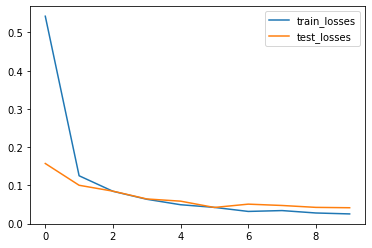

In [8]:
plt.plot(train_losses, label="train_losses")
plt.plot(test_losses, label="test_losses")
plt.legend()
plt.show()

In [9]:
# Accuracy
n_correct = 0
n_total = 0
for inputs, targets in train_loader:
  inputs = inputs.view(-1,28,28)
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs,1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total


# test accuracy
n_correct = 0
n_total = 0
for inputs, targets in test_loader:
  inputs = inputs.view(-1,28,28)
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs,1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")


Train acc: 0.9950, Test acc: 0.9887


In [10]:
#plot Confusion Matrix 
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='confusion_matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'
  """

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Confusion Matrix without Normalization")
  
  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             ha='center', # horizontalalignment
             va='center', # verticalalignment
             color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()

Confusion Matrix without Normalization
[[ 975    0    0    1    0    0    2    1    1    0]
 [   0 1128    2    1    0    0    0    1    1    2]
 [   1    1 1027    0    1    0    0    2    0    0]
 [   0    0    3 1002    0    2    0    1    1    1]
 [   1    0    1    0  964    0    5    2    1    8]
 [   2    0    2    8    0  876    1    0    3    0]
 [   2    4    2    0    0    3  946    0    1    0]
 [   1    1   10    0    0    0    0 1016    0    0]
 [   0    0    2    3    1    4    1    3  956    4]
 [   0    0    0    0    6    3    0    3    0  997]]


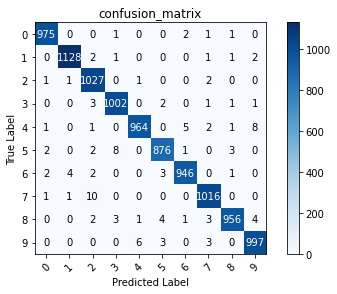

In [12]:
# Get all predictions in an array and plot confusion matrix
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
  # Move data to GPU
  inputs = inputs.view(-1,28,28)
  inputs = inputs.to(device)

  # Forward Pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)

  # Update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

Text(0.5, 1.0, 'True label: 0 - Predicted: 6')

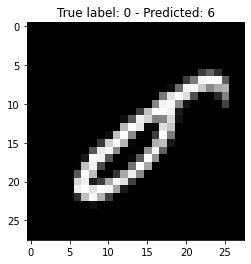

In [18]:
# Show Some misclassified example
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap="gray")
plt.title(f"True label: {y_test[i]} - Predicted: {p_test[i]}")